# Analysing Vaccine Perception of Twitter Users

Our goal is to understand what the users of Twitter think about COVID-19 vaccines. By doing so, we hope to learn about the key factors that influence vaccine adoption. The information gained can be used by public health official to form effective vaccination campaigns in the future.

## Hypothesis
We hypothesise that government regulations related to the pandemic and the kind of news spreading online can affect vaccine perception of social media users online.

## Analysis performed
- Text Sentiment Analysis (VADER)
- Word Cloud
- Topic Modelling (LDA)
- Semantic Network Analysis

## Import relevant packages

In [1]:
# import pandas
import pandas as pd

# import numpy
import numpy as np

# import re
import re

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# import wordcloud
from wordcloud import WordCloud

# download vader lexicon from nltk
import nltk
nltk.download('vader_lexicon')

# import sentimentintensityanalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import word_tokenize
from nltk.tokenize import word_tokenize

# import stopwords
from nltk.corpus import stopwords

# import lemmatizer
from nltk import WordNetLemmatizer
nltk.download('omw-1.4')

# import spacy
import spacy

# import gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import LDA visualisation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# import seaborn
import seaborn as sns

# import datetime
from datetime import datetime as dt

# import networkx
import networkx as nx

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Guga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Guga\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Preparation

We would first need to read the tweets that we have scraped. You may also use the dataset that we scraped (we scrapped tweets from Jan 2021 - Mar 2023). Please find it under the `data` folder.

In [2]:
# read dataset
tweets = pd.read_csv("data/tweet_three_analysis.csv")

# understand shape
print("Shape of dataset:", tweets.shape)

# see first three rows of dataset
tweets.head(3)

Shape of dataset: (685250, 9)


,Datetime,Tweet Id,Text,Username,Retweet Count,Reply Count,Like Count,Hashtags,Lang
0,2021-01-01 23:59:04+00:00,1345157623910436866,"Almost 13,000 Pfizer-BioNTech vaccines were gi...",BBCWalesNews,5,25,18,NaN,en
1,2021-01-01 23:59:03+00:00,1345157623147073537,"@LindaBauld Prof Linda, why not leave Pfizer p...",GMQed,0,1,1,NaN,en
2,2021-01-01 23:58:13+00:00,1345157413519953931,The reality is that @pfizer is charging far to...,Anna_Marriott,11,0,14,NaN,en


Let's clean the data and perform some pre-processing on the Text column so that the dataset will be ready for analysis

In [3]:
# check for duplicates
num_duplicated_rows = tweets.duplicated(subset=['Text']).sum()
print("Number of duplicated rows:", num_duplicated_rows)

# remove duplicates
tweets = tweets.drop_duplicates(subset=['Text'])

# see shape
print("Shape of dataset:", tweets.shape)

Number of duplicated rows: 295368
Shape of dataset: (389882, 9)


To gain a better understanding of the dataset it is imperative that we look at its summary statistics. This step can sometimes reveal key information that could be useful in gaining better insights from the results of analysis done.

In [4]:
# summary statistics
tweets.describe()

,Tweet Id,Retweet Count,Reply Count,Like Count
count,3.898820e+05,389882.000000,389882.000000,389882.000000
mean,1.457431e+18,4.006302,1.398533,14.737903
std,7.808396e+16,105.803604,19.671277,424.398379
min,1.344796e+18,0.000000,0.000000,0.000000
25%,1.392989e+18,0.000000,0.000000,0.000000
50%,1.441018e+18,0.000000,0.000000,1.000000
75%,1.512528e+18,0.000000,1.000000,2.000000
max,1.631082e+18,40783.000000,4351.000000,184570.000000


The above output shows us that the average user tweet has 4 retweets, 14 likes, and 1 reply. Since it is quite low we should note that most of these tweets did not go "viral". This **could** indicate that these tweets are not very informative or controversial enough to be shared more by Twitter users.
<br><br>
However, we should also note that this is not indicative of the entire sample gathered as the 'std' (i.e., standard deviation) is very high.
<br><br>
Now we can start with the data preparation proper. First, we will be processing the `Text` column into `SA_Text` and `TM_Text`. These columns will be used for Sentiment Analysis and Topic Modelling accordingly.

In [5]:
# data cleaning function for sentiment analysis model
def sa_processing(text):
    
    # remove url links
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)

    # remove mentions
    text = re.sub("@[A-Za-z0-9_]+","", text)
    
    # remove whitespaces
    text = " ".join(text.split())
    
    # transform "&amp" and other special chars
    text = text.replace("&quot;", '"')
    text = text.replace("&amp;", "&")
    text = text.replace("&lt;", "<")
    text = text.replace("&gt;", ">")
    text = text.replace("&nbsp;", "")
    
    return text

# data cleaning function for topic modeling analysis
def tm_processing(text):
    
    # check for empty tweets
    if pd.isna(text) == True:
        return ""
    
    # lower all the letters
    text = text.lower()
    
    # remove mentions and hashtags
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    
    # remove links
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    
    # remove punctuations
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    
    # remove "&amp" and other special chars
    text = text.replace("&quot;", '"')
    text = text.replace("&amp;", "&")
    text = text.replace("&lt;", "<")
    text = text.replace("&gt;", ">")
    text = text.replace("&nbsp;", "")
    
    # filter non-alphanumeric characters
    text = re.sub("[^a-z0-9]"," ", text)
    
    # tokenise text
    tokens = word_tokenize(text)
    
    # lemmatize text
    wnl = WordNetLemmatizer()
    
    # lemmatizing the word "was" and "has" returns "wa" and "ha" respectively - hence I didn't include them
    # instead, it should be noted that the term will be removed by the 'stopwords' code chunk below
    exclude_words = ["was", "has"]
    tokens = [wnl.lemmatize(w) for w in tokens if w not in exclude_words]
    
    # remove stop words -> from nltk library
    stop_words = set(stopwords.words('english'))
    text = [w for w in tokens if not w.lower() in stop_words]
    
    return text
    
# apply data cleaning functions
tweets['SA_Text'] = tweets['Text'].apply(lambda x: sa_processing(x))
tweets['TM_Text'] = tweets['Text'].apply(lambda x: tm_processing(x))

# view dataframe
tweets.head(3)

<>:43: DeprecationWarning: invalid escape sequence \[
<>:43: DeprecationWarning: invalid escape sequence \[
C:\Users\Guga\AppData\Local\Temp/ipykernel_26788/4074316905.py:43: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]',' ', text)


,Datetime,Tweet Id,Text,Username,Retweet Count,Reply Count,Like Count,Hashtags,Lang,SA_Text,TM_Text
0,2021-01-01 23:59:04+00:00,1345157623910436866,"Almost 13,000 Pfizer-BioNTech vaccines were gi...",BBCWalesNews,5,25,18,NaN,en,"Almost 13,000 Pfizer-BioNTech vaccines were gi...","[almost, 13, 000, pfizer, biontech, vaccine, g..."
1,2021-01-01 23:59:03+00:00,1345157623147073537,"@LindaBauld Prof Linda, why not leave Pfizer p...",GMQed,0,1,1,NaN,en,"Prof Linda, why not leave Pfizer plans as they...","[prof, linda, leave, pfizer, plan, using, le, ..."
2,2021-01-01 23:58:13+00:00,1345157413519953931,The reality is that @pfizer is charging far to...,Anna_Marriott,11,0,14,NaN,en,The reality is that is charging far too high a...,"[reality, charging, far, high, price, vaccine,..."


Hm... the `Datetime` column shows us the time that the tweet was posted. I would like a column with only the month and year of the tweets reflected. Doing so will help us visualise all the tweets on a monthly basis. Here's how we can create a `Month-Year` column:

In [6]:
# function to change datetime format into just month and year
def change_datetime(datetime_str):
    temp = datetime_str.split("+")[0]
    result = dt.strptime(temp, '%Y-%m-%d %H:%M:%S')
    output = dt.strftime(result, '%y-%m')
    return output

tweets['Month-Year'] = tweets['Datetime'].apply(lambda x: change_datetime(x))

Now, we can start to measure the sentiment of the tweet using **VADER**. We will first use `SentimentIntensityAnalyzer()` from **VADER** to calculate the compound scores for each tweet. These scores will then be used to label the tweet as "Postive", "Negative", or "Neutral". We will be going through what the compound score means in the next section.

In [7]:
# using SentimentIntensityAnalyzer() to give score for each tweet
sid = SentimentIntensityAnalyzer()
tweets['Score'] = tweets['SA_Text'].apply(lambda Text: sid.polarity_scores(Text))

tweets.head(3)

,Datetime,Tweet Id,Text,Username,Retweet Count,Reply Count,Like Count,Hashtags,Lang,SA_Text,TM_Text,Month-Year,Score
0,2021-01-01 23:59:04+00:00,1345157623910436866,"Almost 13,000 Pfizer-BioNTech vaccines were gi...",BBCWalesNews,5,25,18,NaN,en,"Almost 13,000 Pfizer-BioNTech vaccines were gi...","[almost, 13, 000, pfizer, biontech, vaccine, g...",21-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,2021-01-01 23:59:03+00:00,1345157623147073537,"@LindaBauld Prof Linda, why not leave Pfizer p...",GMQed,0,1,1,NaN,en,"Prof Linda, why not leave Pfizer plans as they...","[prof, linda, leave, pfizer, plan, using, le, ...",21-01,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou..."
2,2021-01-01 23:58:13+00:00,1345157413519953931,The reality is that @pfizer is charging far to...,Anna_Marriott,11,0,14,NaN,en,The reality is that is charging far too high a...,"[reality, charging, far, high, price, vaccine,...",21-01,"{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp..."


Here is how we will be labelling the tweets based on the compound score:

In [8]:
# Labelling Tweets using Compound Score
def sentimentlabelling(score):
    
    # if the score is more than or equals to 0.05 it will be labelled positive
    if score["compound"] >= 0.05:
        return "positive"
    
    # if the score is less than or equals to -0.05 it will be labelled negative
    elif score["compound"] <= -0.05:
        return "negative"
    
    # the rest are labelled neutral
    else:
        return "neutral"

tweets["Label"] = tweets["Score"].apply(lambda x: sentimentlabelling(x))

Here is how you can separate the scores into different columns instead of having it all in one column:

In [9]:
# create separate columns for all types of scores
tweets["Positive_Score"] = tweets['Score'].astype(str).str.split(',').str[2].str.split(':').str[-1].astype(float)
tweets["Negative_Score"] = tweets['Score'].astype(str).str.split(',').str[0].str.split(':').str[-1].astype(float)
tweets["Neutral_Score"] = tweets['Score'].astype(str).str.split(',').str[1].str.split(':').str[-1].astype(float)
tweets["Compound_Score"] = tweets['Score'].astype(str).str.split(',').str[3].str.split(':').str[-1].str[0:-1].astype(float)

With that, the data preparation is done! Let's view the processed dataframe:

In [10]:
tweets.head(3)

,Datetime,Tweet Id,Text,Username,Retweet Count,Reply Count,Like Count,Hashtags,Lang,SA_Text,TM_Text,Month-Year,Score,Label,Positive_Score,Negative_Score,Neutral_Score,Compound_Score
0,2021-01-01 23:59:04+00:00,1345157623910436866,"Almost 13,000 Pfizer-BioNTech vaccines were gi...",BBCWalesNews,5,25,18,NaN,en,"Almost 13,000 Pfizer-BioNTech vaccines were gi...","[almost, 13, 000, pfizer, biontech, vaccine, g...",21-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.000,0.0,1.000,0.0000
1,2021-01-01 23:59:03+00:00,1345157623147073537,"@LindaBauld Prof Linda, why not leave Pfizer p...",GMQed,0,1,1,NaN,en,"Prof Linda, why not leave Pfizer plans as they...","[prof, linda, leave, pfizer, plan, using, le, ...",21-01,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",positive,0.160,0.0,0.840,0.6856
2,2021-01-01 23:58:13+00:00,1345157413519953931,The reality is that @pfizer is charging far to...,Anna_Marriott,11,0,14,NaN,en,The reality is that is charging far too high a...,"[reality, charging, far, high, price, vaccine,...",21-01,"{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp...",positive,0.098,0.0,0.902,0.3400


## Text Sentiment Analysis using VADER

As we covered, earlier we had calculated the sentiment of each tweet using the compound score of `SentimentIntensityAnalyzer()` from **VADER**. The **compound score** is the sum of positive, negative & neutral scores, normalized between -1 and +1. We used it as it is more reliable since it encompasses the overall sentiment of the corpus.
<br><br>
Let's take a look at how many tweets are positive, negative, and neutral:

Pct of positive tweets 0.43
Pct of negative tweets 0.3
Pct of neutral tweets 0.27
Mean compound score of all tweets: 0.07


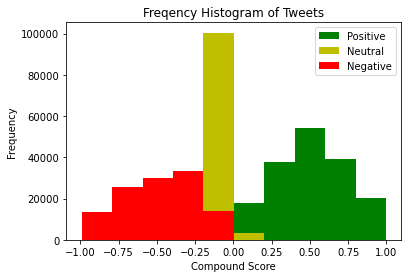

In [11]:
# creating a list of all the scores to plot a freq. diagram
pos_cs = []
neg_cs = []
neu_cs = []

for index, tweet in tweets.iterrows():
    temp = tweet["Score"]["compound"]
    if temp <= -0.05:
        neg_cs.append(temp)
    elif temp >= 0.05:
        pos_cs.append(temp)
    else:
        neu_cs.append(temp)

# print out percentage of each type of tweet
num_records = tweets.shape[0]
print("Pct of positive tweets", round(len(pos_cs)/num_records, 2))
print("Pct of negative tweets", round(len(neg_cs)/num_records, 2))
print("Pct of neutral tweets", round(len(neu_cs)/num_records, 2))

# show mean compound score of all tweets
print("Mean compound score of all tweets:", round(tweets['Compound_Score'].mean(),2))

# plot the frequency diagram
plt.hist([neg_cs, neu_cs, pos_cs], label = ["Negative", 'Neutral', 'Positive'], color = ['r', 'y', 'g'], histtype = 'stepfilled')
plt.gca().set(title = 'Freqency Histogram of Tweets', xlabel = 'Compound Score', ylabel = 'Frequency')
plt.legend()
plt.show()

The frequency diagram  above illustrates the frequency of the different compound scores. It gives us a clear visual on the distribution of the tweets and how much of the tweets belong to which sentiment. We also see that the majority of tweets are positive (43%). We can also see that the mean compound score of all tweets is 0.07. **Hence, we can infer that the perception of vaccines are generally more positive amongst Twitter users.** Later on we will perform topic modelling using LDA to dig deeper and answer what drives these different sentiments of the vaccines.

### Time Series Analysis

We would also like to visualise the distribution of these tweets over time. This will help us in understanding any particular trend over time. It can show us if any key events were influential in informing people's opinions on vaccines. Here are two graphs to show the number of tweets collected over the 2 year period. The first graph just shows us the number of tweets while the second one shows us the overall sentiment (i.e., mean `Compound_Score`) of each `Month-Year`.

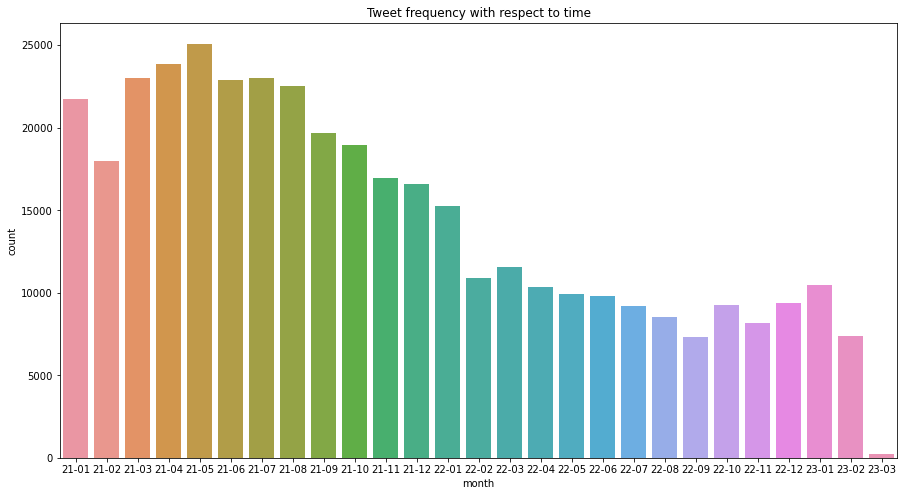

In [12]:
# we would like to visualise the data across month-year

tweets_grped = tweets.groupby('Month-Year')

# get the compound_score data to be used as hue
compound_score = tweets_grped['Compound_Score'].mean()

# get count of tweets
n = tweets_grped.size()

# configuring scale for colorbar
norm = plt.Normalize(compound_score.min(), compound_score.max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# get tweet count data to just see the distribution of frequency over the different month-year(s)
count_df = tweets_grped.count().reset_index()

# set layout of chart
plt.figure(figsize=(15,8))
ax0 = sns.barplot(x=count_df["Month-Year"], y=count_df["Text"])
ax0.set_title("Tweet frequency with respect to time")
ax0.set(xlabel="month", ylabel="count")
plt.show()

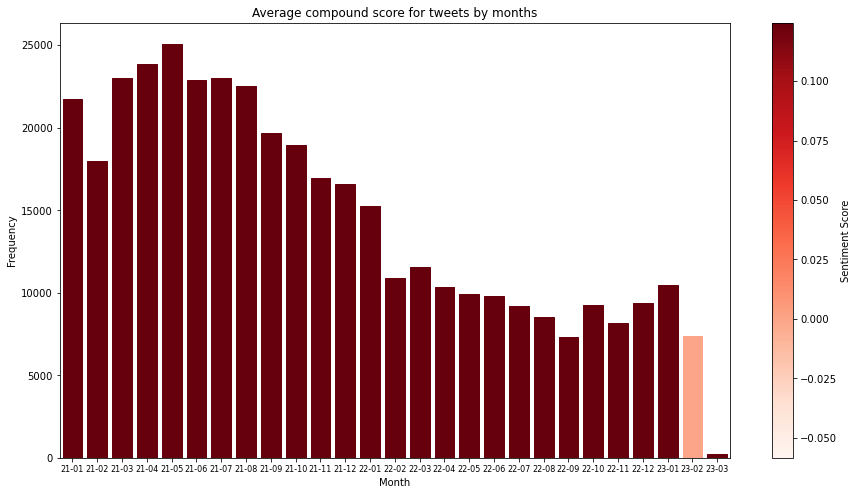

In [13]:
# set layout of charts
plt.figure(figsize=(15,8))

# create barchart with color palette
ax1 = sns.barplot(x=n.index, y=n, hue=compound_score, palette = "Reds", dodge=False)

# set color of bars to match colorbar
for i, container in enumerate(ax1.containers):
    color = sm.to_rgba(i)
    for bar in container:
        bar.set_color(color)

# set color of bars to match colorbar
ax1.set_title("Average compound score for tweets by months")
ax1.set(xlabel="Month", ylabel="Frequency")
ax1.get_legend().remove()
ax1.figure.colorbar(sm, label = 'Sentiment Score')
ax1.tick_params(axis = 'x', which = 'major', labelsize = 8)
plt.show()

The chart shows us that the number of tweets surrounding vaccinations peaked on May 2021 with an average compound score of 0.124 which highlights that the tweets were more positive than negative. There were several events that took place around this time that sparked debates and discussions on Twitter. For instance, the CDC released new guidelines on the 13th of May that fully vaccinated individuals could safely stop wearing masks in most settings. Additionally, on 12 May 2021, the White House COVID response team announced that the US was expanding eligibility for COVID-19 vaccines to all individuals aged 12 and older.
<br><br>
However, it should be noted that there was a sudden drop in the compound score on Feb 2023. So why did this happen? Well, during this month Twitter user @ProjectVaritas released video “evidence” of a Pfizer executive revealing how vaccines interfered with women's’ hormones. This created an onslaught of tweets that denounced pfizer and their vaccines under the #Pfertility. While this was proved to be fake by many media outlets, the video had mislead many with over 40.7 thousand retweets which illustrates just how easy it is to sway public opinion on vaccines.
<br><br>
Here is a screenshot of that post:
<br>
![](images/project_veritas_tweet.png)

## Topic Modelling

This analysis will help us find out key themes that has resulted in/led to a negative outlook of the COVID-19 vaccines. We will be using the Latent Dirichlet Allocation (LDA) algorithm for this. We will first start of by creating a **Word Cloud** to observe the most common words in the tweets. Then we will create the LDA model.

### Word Clouds

We need to create a word cloud for the tweets in the data set. This will let us see the common words that have appeared in these tweets which can give us hints towards why the tweets are labelled as positive or negative. Here is how we can create three different word clouds for each of the different sentiments:

In [14]:
# create a dataframe for each tweet label
positive_tweets = tweets[tweets['Label'] == "positive"]
negative_tweets = tweets[tweets['Label'] == "negative"]
neutral_tweets = tweets[tweets['Label'] == "neutral"]

In [15]:
# create generic function to generate wordcloud

def generate_wordcloud(df, title):
    
    # initialise variables
    all_words = ""
    count = 0
    covid_keywords = ['pfizer', 'biontech', 'sinopharm', 'sinovac', 'moderna', 'astrazeneca', 'covaxin', 'sputnik v']
    vaccine_keywords = ['vaccine', 'vaccinations', 'vaccines', 'immunization', 'vaccinate', 'vaccinated']
    
    # loop through all tweets in df
    for index, tweet in df['TM_Text'].items():
        
        if index < len(df) - 1:
            for word in tweet:
                
                # let's make sure all words do not include search terms used to scrape the tweets
                # assumption: most tweets will have the keywords and they will be read as most common words
                if word not in covid_keywords:
                    if word not in vaccine_keywords:
                        
                        # creating string of words as input into the word cloud
                        all_words += word + " "
        else:
            for word in tweet:
                if word not in covid_keywords:
                    if word not in vaccine_keywords:
                        all_words += word
    
    # create word cloud
    wordcloud = WordCloud(background_color ='white', min_font_size = 10).generate(all_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

Common words for tweets that are positive


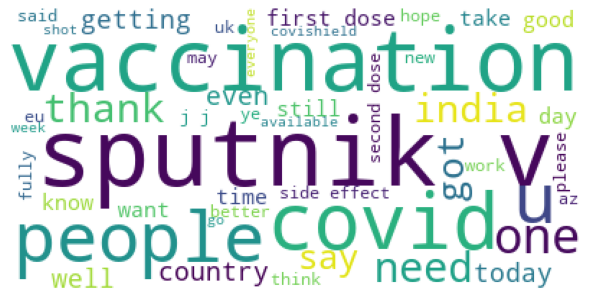

Common words for tweets that are negative


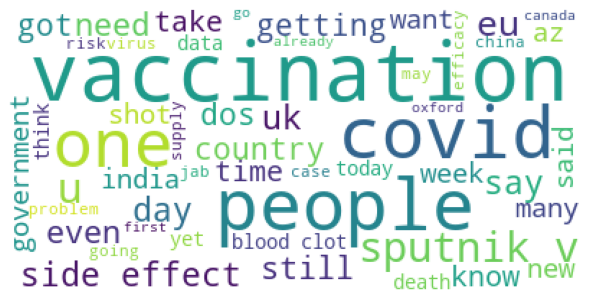

In [16]:
# run the generate_wordcloud() function
print("Common words for tweets that are positive")
positive_wordcloud = generate_wordcloud(positive_tweets, "Common Words in Positive Tweets")
print("Common words for tweets that are negative")
negative_wordcloud = generate_wordcloud(negative_tweets, "Common Words in Negative Tweets")

The positive tweets seem to be positive because users are happy to finally get their vaccines, we can see this from words like "getting", "thank", "first dose", "available". On the other hand, the negative tweets seem to be more concerned with "side effect(s)", "risk", "death" which hint at the low levels of trust in the vaccines.
<br><br>
This is interesting as it shows us that tweets with negative sentiments towards vaccines could be driven by fear and low levels of trust. If this is so, policy makers and health officials should therefore focus on ensuring the relevant vaccine data is made available to the public and focus on alleviating worries to improve the sentiment of the COVID-19 vaccines.
<br><br>
But let's not get ahead of ourselves, these word clouds are not sufficient to gather any concrete evidence that this is the case. That's why we will be analysing the tweets with topic modelling. For our analysis, we will be using the **Latent Dirichlet Allocation (LDA)** model.

### Latent Dirichlet Allocation (LDA)
First we will create a [bag of words](https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971). We will be using **Gensim**'s Dictionary constuctor to give each word a unique identifier, with that we can find out how many times a word token occurs within a tweet.
<br><br>
We will be performing LDA on the negative and positive tweets to better understand what drives them. Here is the code to do so:

In [17]:
# create an id2word dictionary - map each word to an id
positive_words = positive_tweets['TM_Text']
negative_words = negative_tweets['TM_Text']

id2word_positive = corpora.Dictionary(positive_words)
id2word_negative = corpora.Dictionary(negative_words)

# creating the corpus
positive_corpus = []
negative_corpus = []

for text in positive_words:
    
    # creating a bag of words for positive tweets -> frequency of unique words
    pos_new = id2word_positive.doc2bow(text)
    positive_corpus.append(pos_new)
    
for text in negative_words:
    
    # creating a bag of words for negative tweets
    neg_new = id2word_negative.doc2bow(text)
    negative_corpus.append(neg_new)
    
# now we have the corpus - let's print it to see what it looks like
print(positive_corpus[0][0:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


The corpus is essentially a `list` of `tuples` where the first element is the id of a word and the second element is the number of times it appears (i.e., the frequency of the term). Let's calibrate the models:

In [18]:
# creating the LDA models
positive_lda_model = gensim.models.ldamodel.LdaModel(corpus = positive_corpus,
                                                    id2word = id2word_positive,
                                                    num_topics = 5,
                                                    random_state = 100,
                                                    update_every = 1,
                                                    chunksize = 100,
                                                    passes = 10,
                                                    alpha = "auto")

negative_lda_model = gensim.models.ldamodel.LdaModel(corpus = negative_corpus,
                                                    id2word = id2word_negative,
                                                    num_topics = 5,
                                                    random_state = 100,
                                                    update_every = 1,
                                                    chunksize = 100,
                                                    passes = 10,
                                                    alpha = "auto")

We chose to only include 5 topics so as to not overfit the model. And it worked! You will see later on that all 5 topics generated for both models are not overlapped. We will use the **pyLDAvis** module to help us better visualise the different topics generated:

In [19]:
# visualising the results for analysis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
positive_viz = gensimvis.prepare(positive_lda_model, positive_corpus, id2word_positive, mds="mmds", R=20)
negative_viz = gensimvis.prepare(negative_lda_model, negative_corpus, id2word_negative, mds="mmds", R=20)

C:\Users\Guga\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\Guga\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [20]:
positive_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.137768  0.393174       1        1  34.595929
2     -0.105865 -0.405685       2        1  25.404444
4     -0.403295 -0.014342       3        1  21.346351
3      0.316843 -0.210241       4        1  10.836409
1      0.330084  0.237093       5        1   7.816867, topic_info=            Term           Freq          Total Category  logprob  loglift
19       vaccine  161158.000000  161158.000000  Default  20.0000  20.0000
10        pfizer   89398.000000   89398.000000  Default  19.0000  19.0000
97         covid   55249.000000   55249.000000  Default  18.0000  18.0000
103      moderna   54351.000000   54351.000000  Default  17.0000  17.0000
410   vaccinated   45085.000000   45085.000000  Default  16.0000  16.0000
...          ...            ...            ...      ...      ...      ...
2652         non    2633.520281    2634.380709   Topic5  -4.5558   2.5486
2682       cause    2610.669805    2611.533597   Topic5  -4.5645   2.5486
1752        full    2513.738664    2514.608868   Topic5  -4.6024   2.5485
77          body    2298.656848    2299.522912   Topic5  -4.6918   2.5485
38          hope    2209.141057    2210.004804   Topic5  -4.7316   2.5485

[122 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
248       1  0.999932      1
96        2  0.999962     19
161       1  0.999960      2
120       4  0.999869   2021
69        1  0.999959      3
...     ...       ...    ...
207       3  0.999859   work
269       2  0.999939  world
21        3  0.999878  would
480       1  0.999928   year
1018      3  0.999736    yes

[103 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

Here are the main topics we picked out from the visualisation above:
- Topic 1: Overall effectiveness of the vaccines
- Topic 2: The vaccines are safe and have been trialled and approved
- Topic 3: High trust that the vaccines develop immunity to the virus
- Topic 4: Praising pharma companies for their swift actions
- Topic 5: Interested in the research and science behind the vaccines

The first two topics (which account for over 50% of the tokens) show us that most of the positive tweets are centered around the safety and effectiveness of the vaccines.

In [21]:
negative_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.420186 -0.025142       1        1  42.890233
1      0.143985  0.353386       2        1  19.238795
2     -0.339978 -0.210587       3        1  13.927122
4     -0.309065  0.265883       4        1  13.845219
0      0.084873 -0.383539       5        1  10.098631, topic_info=          Term           Freq          Total Category  logprob  loglift
22     vaccine  108002.000000  108002.000000  Default  20.0000  20.0000
27       covid   37380.000000   37380.000000  Default  19.0000  19.0000
16      pfizer   68429.000000   68429.000000  Default  18.0000  18.0000
258    moderna   33194.000000   33194.000000  Default  17.0000  17.0000
224     people   26260.000000   26260.000000  Default  16.0000  16.0000
...        ...            ...            ...      ...      ...      ...
1981  document    1822.365143    1823.215936   Topic5  -4.8377   2.2923
275       paid    1814.432065    1815.282516   Topic5  -4.8420   2.2923
2112      anti    1707.694960    1708.534584   Topic5  -4.9027   2.2923
1063   chinese    1673.355301    1674.187330   Topic5  -4.9230   2.2923
648      claim    1696.976793    1697.822385   Topic5  -4.9090   2.2923

[125 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
104       4  0.999908      1
25        3  0.999955     19
105       4  0.999887      2
1729      4  0.999693   2021
86        4  0.999918      3
...     ...       ...    ...
721       4  0.999591    way
1219      5  0.999857   well
3074      2  0.999694  woman
337       1  0.999841  would
156       1  0.999888   year

[108 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

Here are the main topics we picked out from the visualisation above:
- Topic 1: Vaccines aren't 100% effective
- Topic 2: About political bodies and pharma companies
- Topic 3: Inability to trust vaccines due to different information online
- Topic 4: Concerning negative side-effects of vaccines
- Topic 5: Political sentiments surrounding China and Russia

The first two topics (which account for over 50% of the tokens) show us that most of the negative tweets are centered around the effectiveness of the vaccines and a lack of trust in the government and pharmaceutical companies that manufacture the vaccines.
<br><br>
Wow... I guess our suspicions that tweets with negative sentiments towards vaccines could be driven by fear and low levels of trust were true after all...

## Semantic Network Analysis

Before we end of our analysis and proceed to give you our conclusion on this topic, let's perform **Semantic Network Analysis (SNA)** on the dataset. It helps us model inter-connections of keywords to gain further understanding of underlying patterns within tweets. To be more specific, we will be modelling words that co-occurred more than 4 times in the entire dataset. Here, we have defined two words to have co-occured if they occurred within the same window. Here's the code to create our own semantic network:

In [22]:
# get texts from dataframe
texts = tweets['TM_Text']

# create an empty undirected graph
graph = nx.Graph()

# define window size
window_size = 3


for idx, text in texts.iteritems():
    
    # split text into windows of size window_size
    word_windows = [text[i:i+window_size] for i in range(len(text)-window_size+1)]
    
    # count co-occurrences of words within windows
    cooccurrence_counts = {}
    for window in word_windows:
        for word1 in window:
            for word2 in window:
                if word1 != word2:
                    if (word1, word2) not in cooccurrence_counts:
                        cooccurrence_counts[(word1, word2)] = 1
                    else:
                        cooccurrence_counts[(word1, word2)] += 1
                        
    # add nodes for each word
    for window in word_windows:
        graph.add_nodes_from(window)

    # add edges with weights corresponding to co-occurrence counts
    for edge, weight in cooccurrence_counts.items():
        graph.add_edge(edge[0], edge[1], weight=weight)

C:\Users\Guga\AppData\Local\Temp/ipykernel_26788/930826089.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, text in texts.iteritems():


In [23]:
# set threshold
threshold_weight = 4

# remove edges with weight < threshold
edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold_weight]
graph.remove_edges_from(edges_to_remove)

# removing nodes with no edges
graph.remove_nodes_from(list(nx.isolates(graph)))

In [24]:
# write graph into .gexf file so that it can be visualised using Gephi
nx.write_gexf(graph, "data/model/semantic_network.gexf")

With the above code we have a network of texts that have occurred in the same window (i.e., within 1 word of each other). We only kept words that co-occurred at least 4 times within a single tweet. Here is a gif of the network graph formed:
<br><br>
![](images/graph_animation.gif)

From the overview of the network you can see that most inter-connections happen within two words. Additionally, few edges have strong connections (i.e., a higher weight - which represents the number of times they have co-occurred) while most edges have a lower weight. It should also be noted that only a handful of nodes have a higher degree centrality (represented by the size of the node).
<br><br>
This type of analysis can also help stakeholders (such as governments or pharmaceutical companies) understand what people think about certain vaccine brands by analysing which words co-occurred frequently with certain brands like "moderna" or "pfizer".
### Word Association

We can use word association to visualize the most salient concepts regarding vaccines. For example, the words "condo" and "covid" have the highest co-occurrence.
![](images/covid_condo.png)
<br><br>They have been used at least 16 times in a single tweet within the 3 word window size defined above. This illustrates how many Twitter users are talking about condominums (especially in the US and in Canada where most of the tweets we have collected comes from). 
<br><br>
We found that the pandemic disrupted housing markets and many condominium building projects were halted. Additionally, houses could not be sold and many people lost tremendous amounts of investment capital. You can find more information here: [When the Cranes (Almost) Stopped: How COVID-19 Impacts the Condo Building Industry](https://www.youtube.com/watch?v=Uqowwfhqn4w). While this gives us little information on the vaccine perception themselves, you can see how the Semantic Netowrk Graph has allowed us to unveil latent semantic relationships and extract tacit knowledge, which may not be readily apparent at the surface-level examination.

![](images/poison_stick.png)
<br>
Additionally, we found that there are strong associations between the words “poison” and “stick”. Subsequent investigations revealed that this is related to cases of poisoning from COVID test kits in the US that further decreased trust that people had in pharmaceutical companies. 

## Conclusion
From the analyses performed above, we understand that despite the fact that a majority of people believe in the COVID-19 vaccine and have positive sentiments towards it, it should be noted that the prevalence of social media has made it easier to sway public opinion through fake news. Hence, government agencies should mitigate this by proactively clamping down on false information online. We also identified that the majority of negative sentiments regarding the vaccines stem from a lack of trust in the vaccines and the pharmaceutical companies that produce them. This is due to the negative side effects and lack of information surrounding these implications. Should another pandemic occur, governments should seek to address this first.

## References

##### Sentiment Analysis:
- [Sentiment Analysis of COVID-19 Analysis Tweets](https://towardsdatascience.com/sentiment-analysis-of-covid-19-vaccine-tweets-dc6f41a5e1af)
- [Twitter Sentiment Analysis on COVID-19 using VADER](https://prastuti.medium.com/twitter-sentiment-analysis-on-covid-19-using-vader-82f030b686a9)
- [Sentiment Analysis Made Easy Using VADER](https://analyticsindiamag.com/sentiment-analysis-made-easy-using-vader/#:~:text=The%20compound%20score%20is%20the,the%20positivity%20of%20the%20text)
- [Social Media Sentiment Analysis in Python With VADER - No Training Required!](https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8)
- [COVID-19 Vaccine-Related Discussion on Twitter: Topic Modeling and Sentiment Analysis](https://pubmed.ncbi.nlm.nih.gov/34115608/)

##### Topic Modelling
- [Improve Topic Modeling Algorithms based on Twitter hastags](https://iopscience.iop.org/article/10.1088/1742-6596/1660/1/012100/pdf)
- [LDA Topic modeling with Tweets](https://towardsdatascience.com/lda-topic-modeling-with-tweets-deff37c0e131)
- [How to Create an LDA Topic Model in Python with Gensim](https://www.youtube.com/watch?v=TKjjlp5_r7o)

##### Semantic Network Analysis
- [Temporal semantic network analysis](https://towardsdatascience.com/temporal-semantic-network-analysis-bd8869c10f10)
- [Text Network Analysis: Theory and Practice](https://towardsdatascience.com/text-network-analysis-theory-and-practice-223ac81c5f07)

##### Done by: S Guganesh